# Pulsar Star Predictor

*Group 006-35: Rapeewit Chanprakaisi, Arav Dewan, Serena Khatwa, Mike Zhang*

## Introduction

A pulsar star is a highly magnetized rotating neutron star which emits electromagnetic radiation beams out of its magnetic poles. Electromagnetic waves produce a detectable pattern of broadband radio emission. However, detection of a pulsar in reality is challenging because radio frequency interferences and radio noise often trigger the detectors and mimic the pulsar star. In this project, we will answer the following question:

*Using our prediction model, how accurately can we predict whether or not a signal is from a pulsar star?*

We will be using the HTRU2 data set which contains pulsar candidates collected during the High Time Resolution Universe Survey to conduct our study. The HTRU2 dataset contains 17898 examples out of which 1639 are real pulsar examples. Each observation is described by 8 continuous variables, and a single class variable. The first 4 are mean, standard deviation, excess kurtosis, and skewness obtained from the integrated pulse profile, while the other 4 are from the DM-SNR curve.

## Methods & Results

In [1]:
#Loading in libaries.
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)
options(repr.matrix.max.rows = 6)
library(httr)
library(readxl)
library(ggplot2)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Reading

In [2]:
#Reading the data set from the web.
pulsar_data <- read_csv("https://raw.githubusercontent.com/rchanpra/dsci100_group_project/main/HTRU2/HTRU_2.csv",
                        col_names = FALSE)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Wrangling

In [3]:
#Adding column names
colnames(pulsar_data) <- c("mean_profile",
                           "deviation_profile",
                           "kurtosis_profile",
                           "skewness_profile",
                           "mean_dmsnr",
                           "deviation_dmsnr",
                           "kurtosis_dmsnr",
                           "skewness_dmsnr",
                           "class")

In [4]:
#Renaming values and factoring the `class` variable.
pulsar_data <- pulsar_data |>
    mutate(class = ifelse(class == 1, "pulsar", "non_pulsar")) |>
    mutate(class = as_factor(class))
#The data is now tidy

In [5]:
pulsar_data |> head(6)

mean_profile,deviation_profile,kurtosis_profile,skewness_profile,mean_dmsnr,deviation_dmsnr,kurtosis_dmsnr,skewness_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,non_pulsar
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,non_pulsar
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,non_pulsar
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,non_pulsar
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,non_pulsar
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,non_pulsar


### Splitting

In [6]:
set.seed(2023)
#splitting the dataset into training and testing data
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

### Summarizing

In [7]:
#Determining the number of rows that have missing data
pulsar_train |> is.na() |> sum()

[1] 0

The dataset used does not have any mising data, hence the value above is 0

In [8]:
#Finding the mean of each continuous variables
pulsar_train |> select(!class) |> map_df(mean)

mean_profile,deviation_profile,kurtosis_profile,skewness_profile,mean_dmsnr,deviation_dmsnr,kurtosis_dmsnr,skewness_dmsnr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
111.1715,46.57221,0.47494,1.751929,12.51202,26.28832,8.29349,104.3026


In [9]:
#Finding the count of each value in class
pulsar_train |> group_by(class) |> summarize(n = n())

class,n
<fct>,<int>
non_pulsar,12195
pulsar,1228


### NOTE:
Alternatively, we can also use the `summary()` function.

In [10]:
pulsar_train |> summary()

  mean_profile     deviation_profile kurtosis_profile  skewness_profile 
 Min.   :  5.812   Min.   :25.22     Min.   :-1.8760   Min.   :-1.7819  
 1st Qu.:100.855   1st Qu.:42.46     1st Qu.: 0.0267   1st Qu.:-0.1900  
 Median :115.141   Median :47.00     Median : 0.2238   Median : 0.1950  
 Mean   :111.171   Mean   :46.57     Mean   : 0.4749   Mean   : 1.7519  
 3rd Qu.:127.070   3rd Qu.:51.02     3rd Qu.: 0.4702   3rd Qu.: 0.9232  
 Max.   :192.617   Max.   :91.81     Max.   : 8.0695   Max.   :68.1016  
   mean_dmsnr       deviation_dmsnr  kurtosis_dmsnr   skewness_dmsnr    
 Min.   :  0.2132   Min.   :  7.37   Min.   :-2.812   Min.   :  -1.965  
 1st Qu.:  1.9293   1st Qu.: 14.49   1st Qu.: 5.731   1st Qu.:  34.366  
 Median :  2.8102   Median : 18.49   Median : 8.416   Median :  82.993  
 Mean   : 12.5120   Mean   : 26.29   Mean   : 8.293   Mean   : 104.303  
 3rd Qu.:  5.4916   3rd Qu.: 28.48   3rd Qu.:10.680   3rd Qu.: 138.690  
 Max.   :223.3921   Max.   :109.71   Max.   :34.540

## Finding Predictor Variables

For the sake of simplicity, we will use 4 predictor variables from either the integrated pulse profile or the DM-SNR curve. 

We will capitalize on the `ggpairs()` function from the `GGally` library to plot the variables against each other with class as the color.

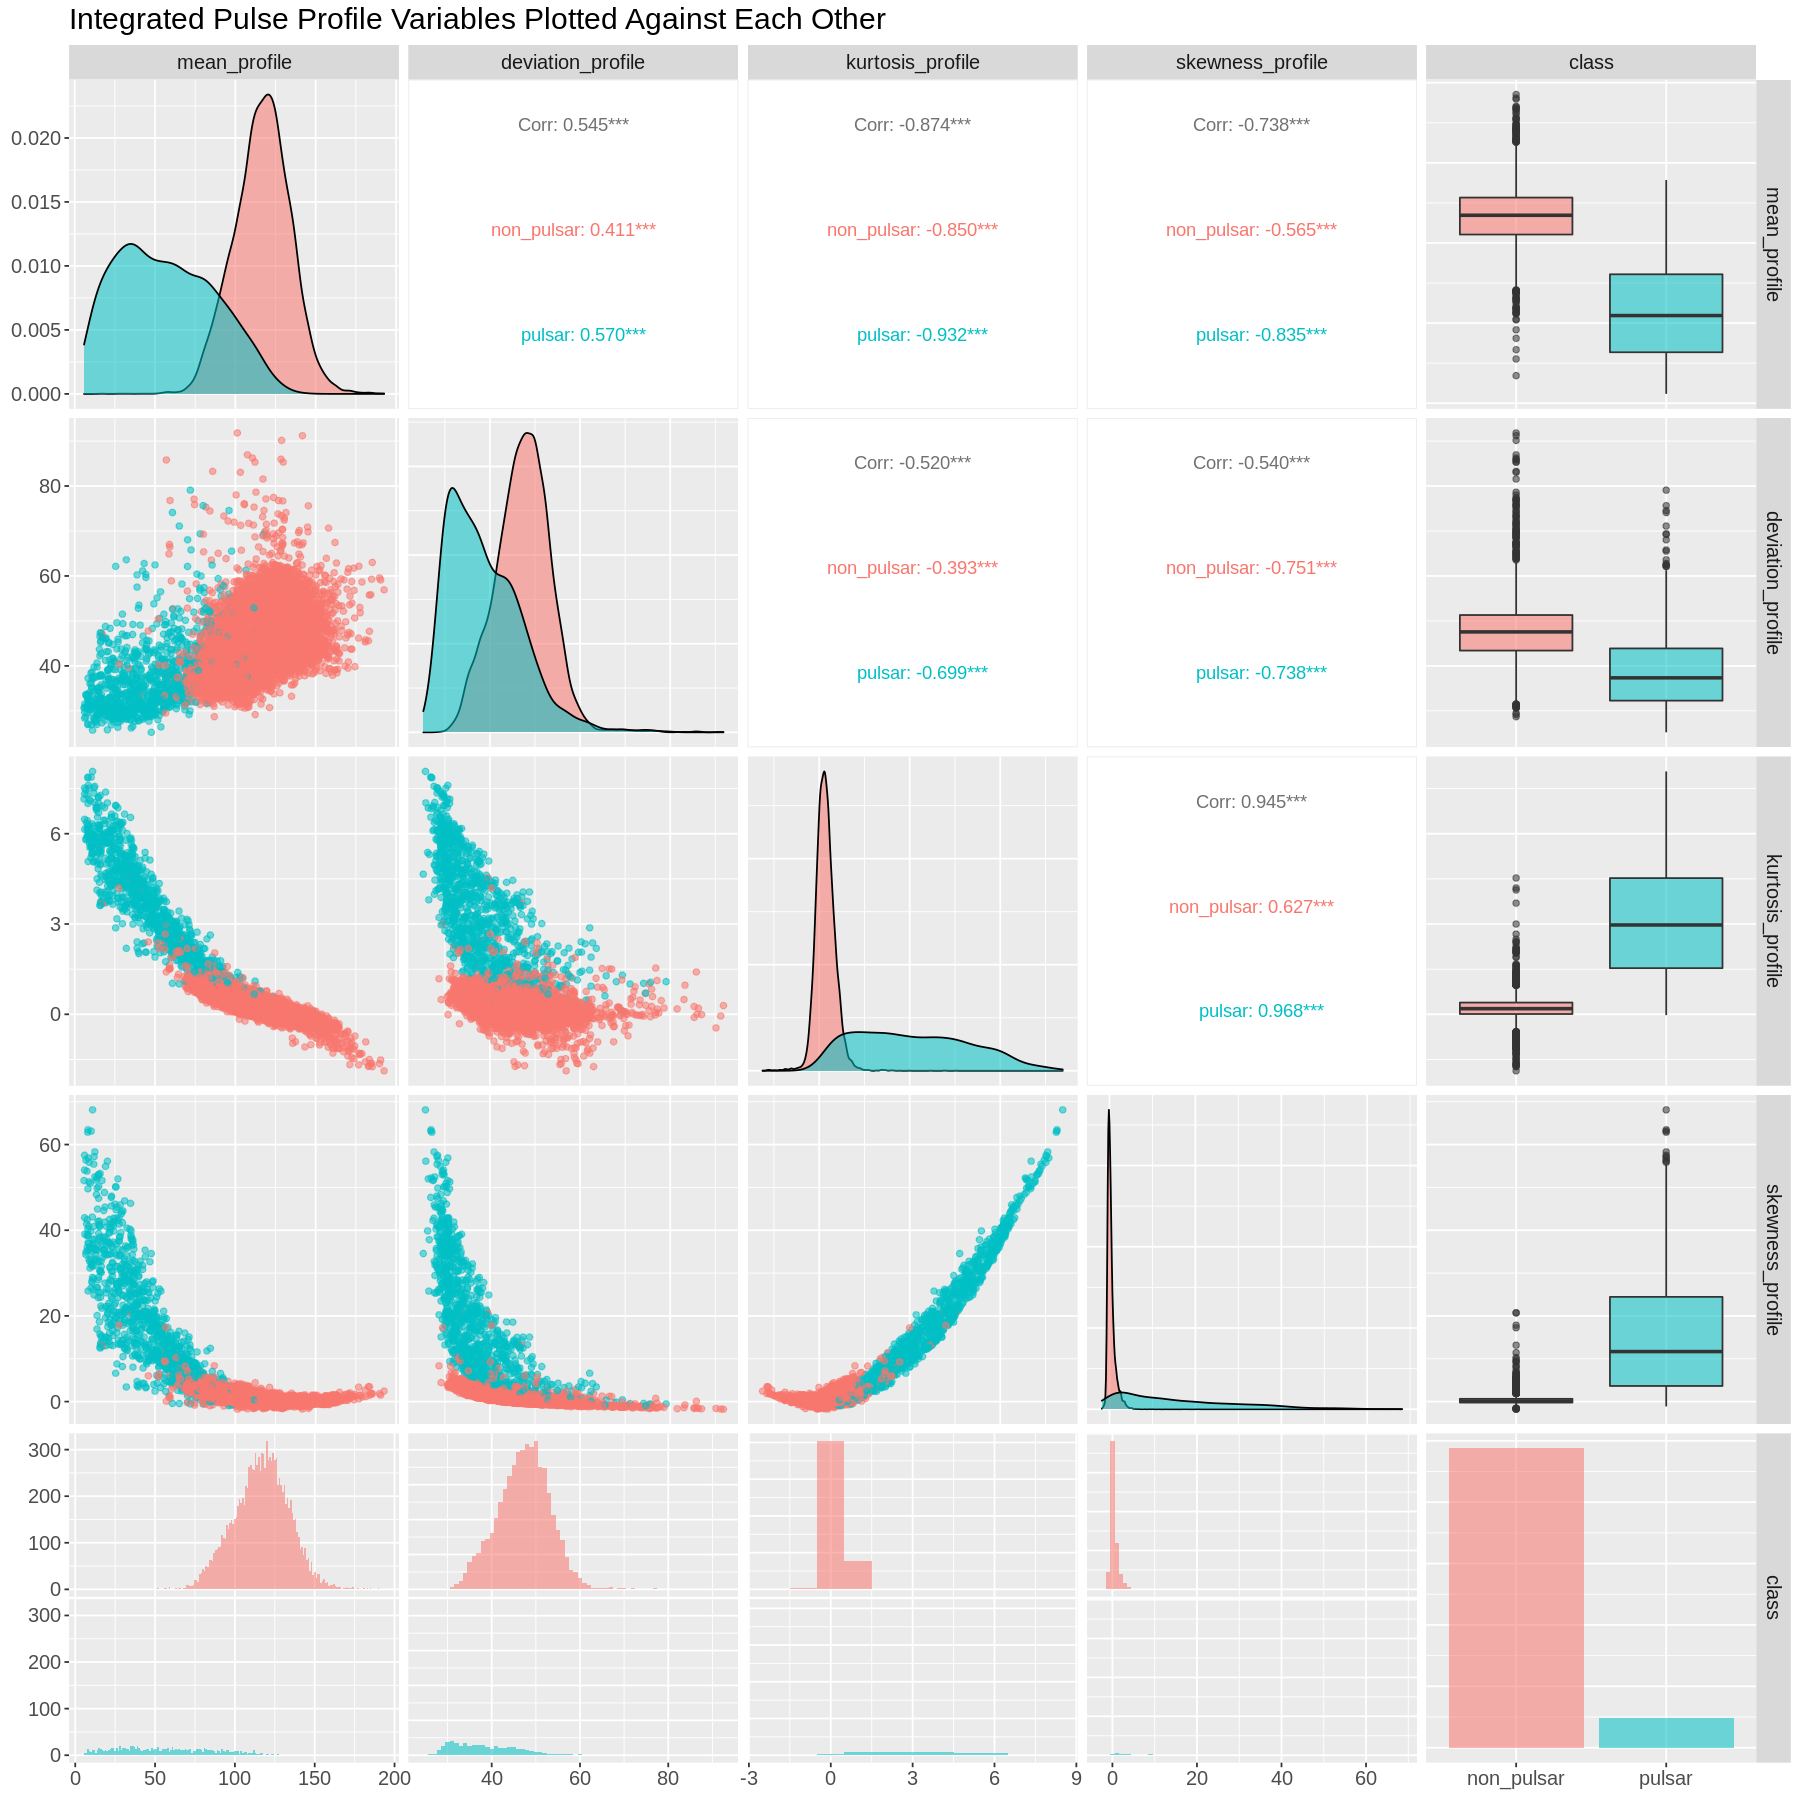

In [11]:
options(repr.plot.width = 15, repr.plot.height = 15)

pulsar_train_profile_plot <- pulsar_train |>
    select(!mean_dmsnr:skewness_dmsnr) |>
    ggpairs(aes(color = class, alpha = 0.5),
            lower = list(combo = wrap("facethist", binwidth = 1))) +
    labs(title = "Integrated Pulse Profile Variables Plotted Against Each Other") +
    theme(text = element_text(size = 15))
pulsar_train_profile_plot

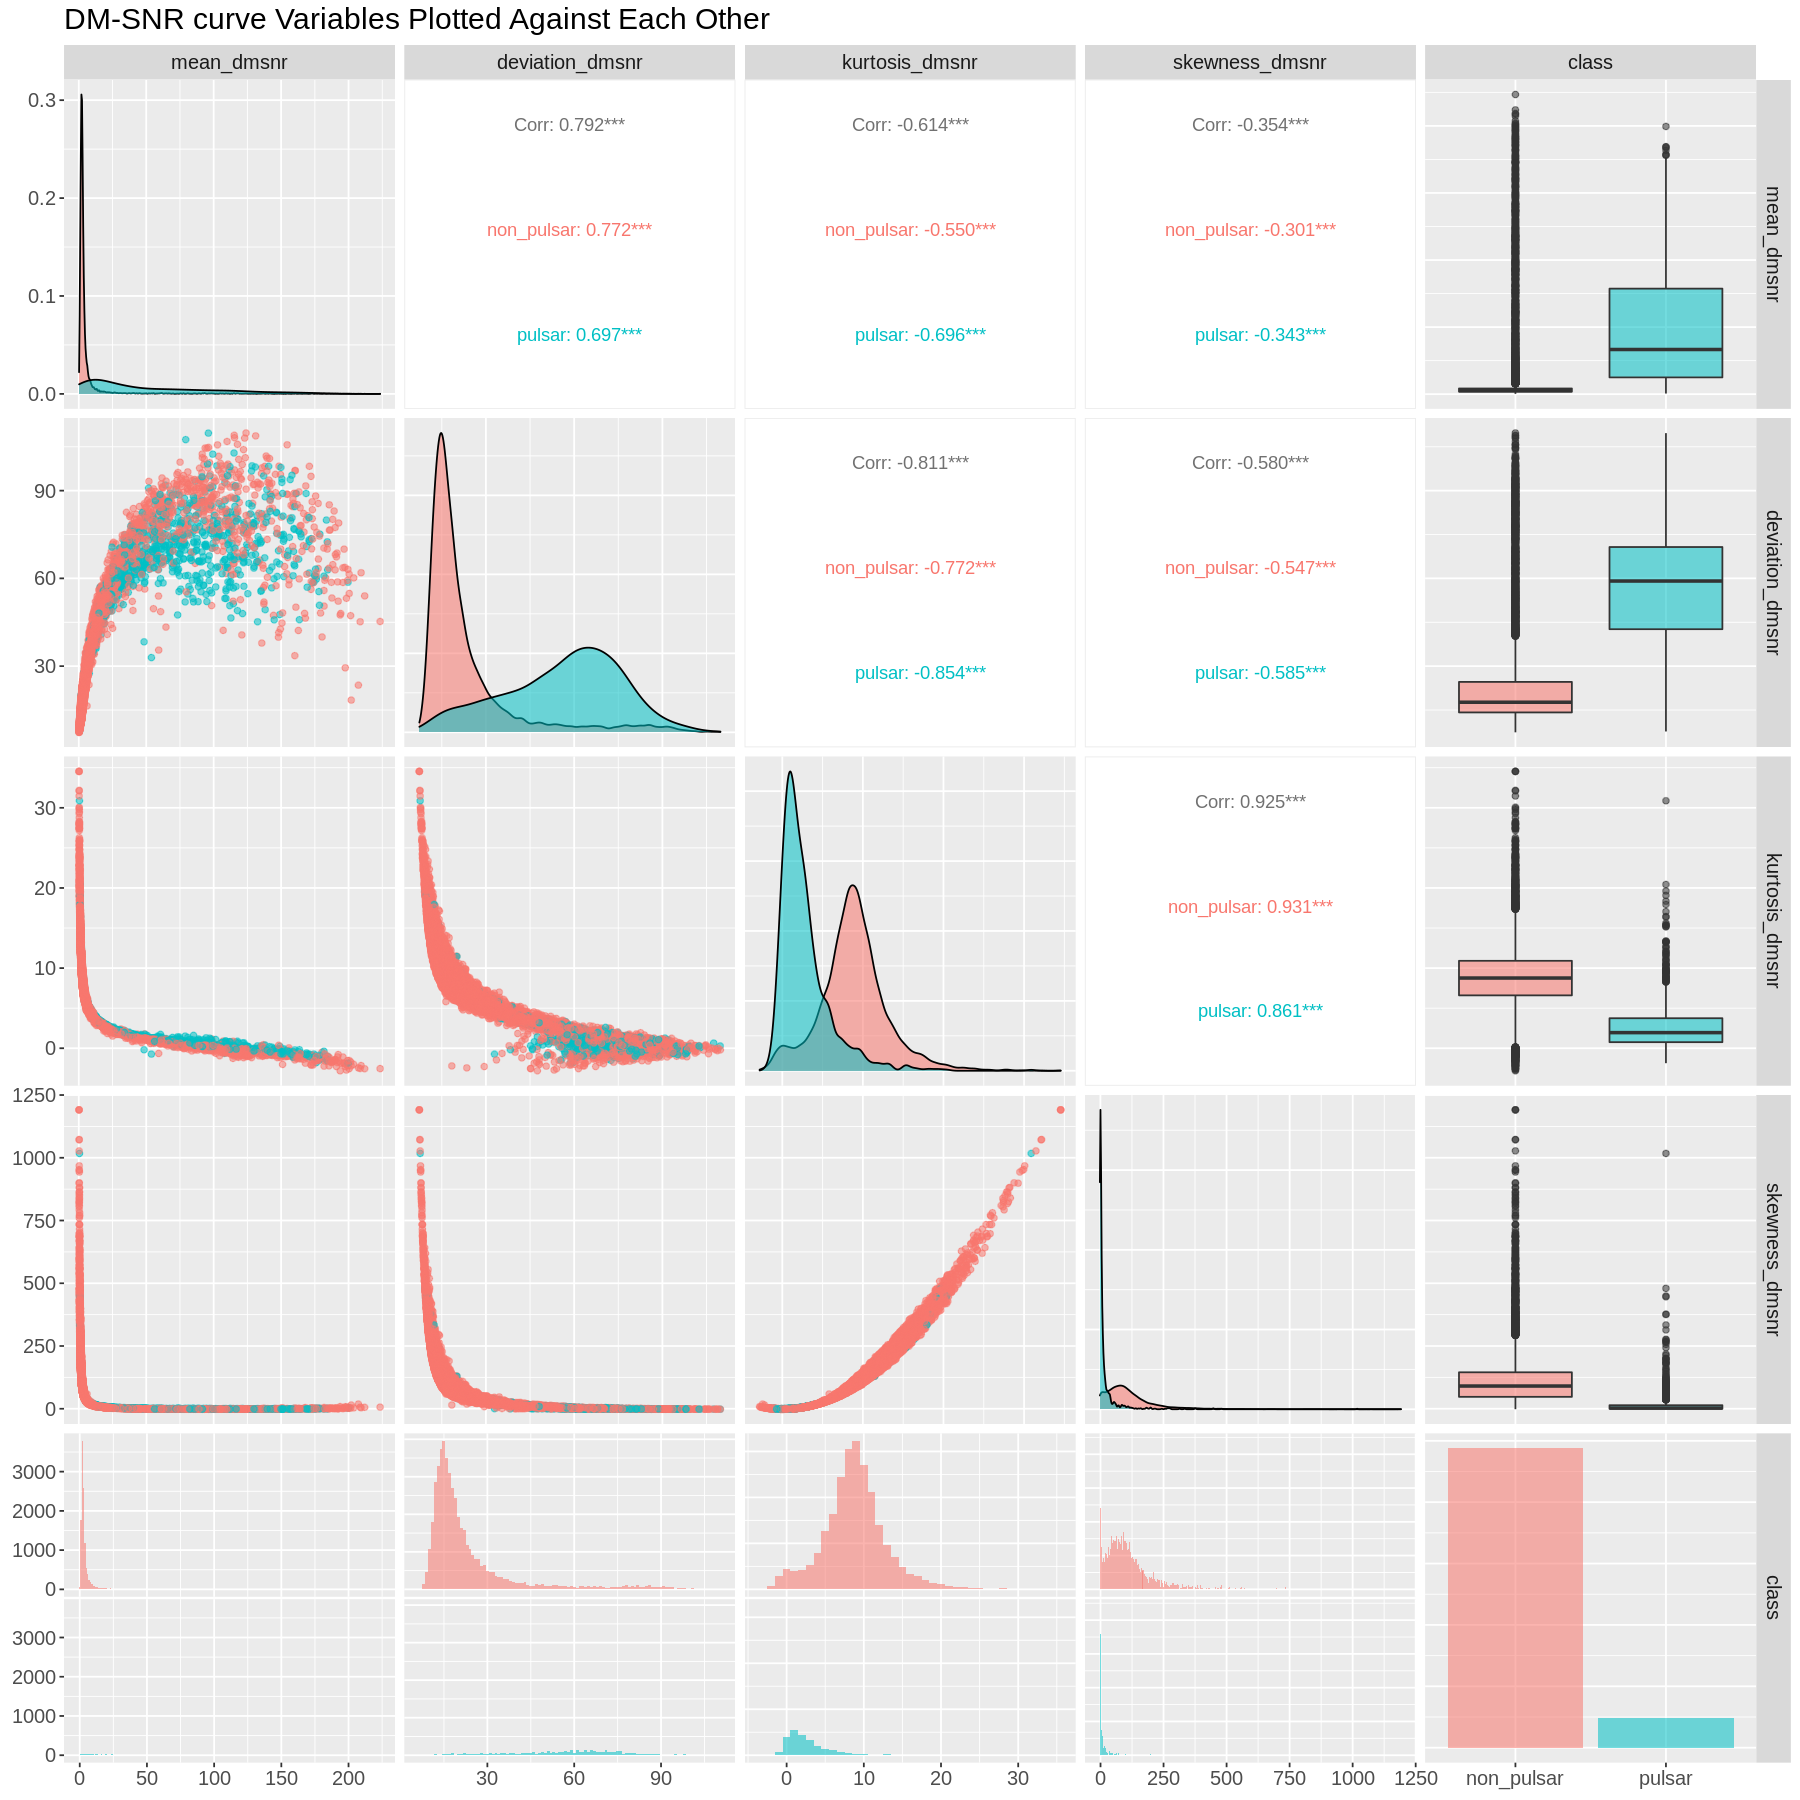

In [12]:
options(repr.plot.width = 15, repr.plot.height = 15)

pulsar_train_dmsnr_plot <- pulsar_train |>
    select(!mean_profile:skewness_profile) |>
    ggpairs(aes(color = class, alpha = 0.5),
            lower = list(combo = wrap("facethist", binwidth = 1))) +
    labs(title = "DM-SNR curve Variables Plotted Against Each Other") +
    theme(text = element_text(size = 15))
pulsar_train_dmsnr_plot

After researching about the parameters, we decided to go with `mean_profile`, `deviation_profile`, `kurtosis_profile`, and `skewness_profile`. These parameters were chosen as our predictors because that these parameters have been considered as essential in finding if a reading is a pulsar star or not(Lyon, 2016).

### Visualizing

In [13]:
#Scaling the predictor variables
pulsar_recipe <- recipe(class ~ mean_profile +
                        deviation_profile + 
                        kurtosis_profile + 
                        skewness_profile, data = pulsar_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())  

pulsar_train_scaled <- pulsar_recipe |>
    prep() |>
    bake(pulsar_train)
pulsar_train_scaled |> head(6)

mean_profile,deviation_profile,kurtosis_profile,skewness_profile,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.1474779,1.33470797,-0.670652802,-0.4013552,non_pulsar
-0.3382447,1.80326142,-0.009094895,-0.3711403,non_pulsar
-0.3184188,-1.05916689,-0.143308166,-0.1147243,non_pulsar
0.9986311,1.55365398,-0.513596128,-0.3909742,non_pulsar
-0.8762891,-0.86425767,0.119029320,-0.1028834,non_pulsar
-0.6871805,0.01844365,0.053844970,-0.2185910,non_pulsar


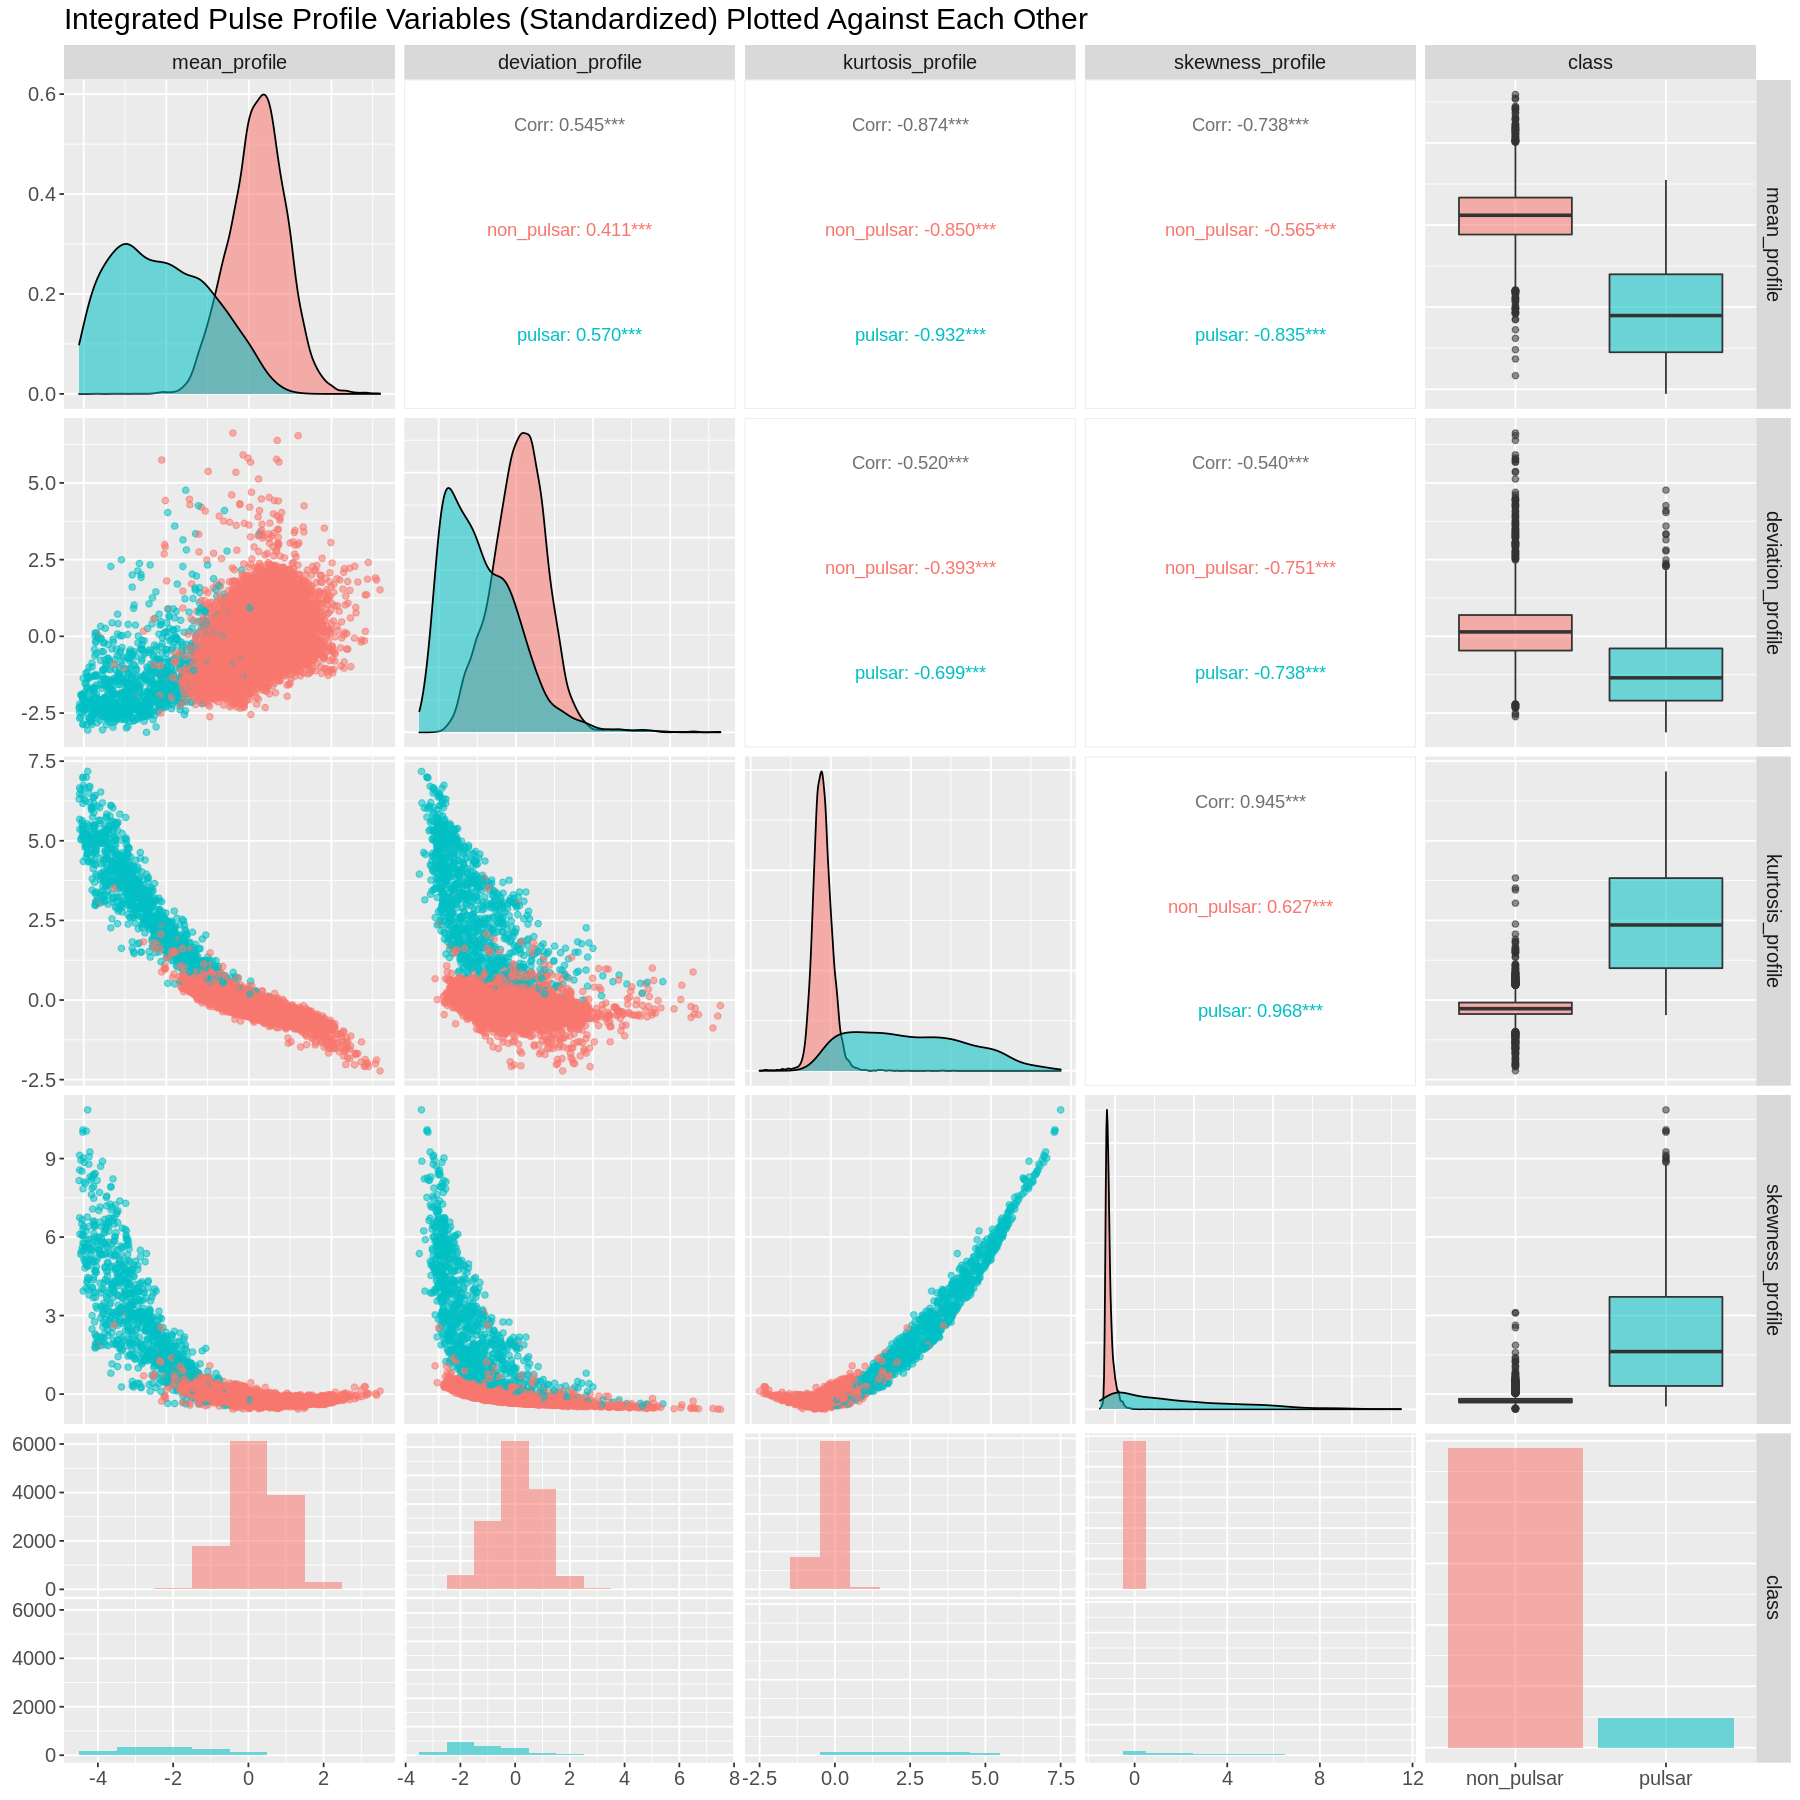

In [14]:
#Plotting the scaled predictor variables against each other
options(repr.plot.width = 15, repr.plot.height = 15)

pulsar_train_scaled_plot <- pulsar_train_scaled |>
    ggpairs(aes(color = class, alpha = 0.5),
            lower = list(combo = wrap("facethist", binwidth = 1))) +
    labs(title = "Integrated Pulse Profile Variables (Standardized) Plotted Against Each Other") +
    theme(text = element_text(size = 15))
pulsar_train_scaled_plot

### Methods

The following 4 variables will be use as our predictor variables: `mean_profile`, `deviation_profile`, `kurtosis_profile`, and `skewness_profile`.

We will use the k-nearest neighbors classification algorithm to build the predictor model, which will be tuned and cross-validated to determine the best value of K to use for the model. The model will then be trained and tested to find its accuracy in predicting pulsar signals.

We are planning to visualize the results of the model by utilizing a scatter plot that is coloured with the correctness of the model for each observation. This will come with an accuracy percentage of the model.

### Performing Data Analysis

In [29]:
set.seed(2023) 
#kknn specification with distance
pulsar_recipe <- recipe(class ~ mean_profile + deviation_profile + kurtosis_profile + skewness_profile, data = pulsar_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())  

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
# performing 5 fold cross validation to find accuracy of different k neighbors
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = class)

knn_results <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = pulsar_vfold, grid = tibble(neighbors = seq(1, 50, 2))) |>
    collect_metrics()

In [30]:
accuracies <- knn_results |> 
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
accuracies |> head(6)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,binary,0.9784696,5,0.0007404588,Preprocessor1_Model06
13,accuracy,binary,0.9784696,5,0.0007770622,Preprocessor1_Model07
15,accuracy,binary,0.9783951,5,0.0009437043,Preprocessor1_Model08
17,accuracy,binary,0.9780970,5,0.0009827877,Preprocessor1_Model09
19,accuracy,binary,0.9780970,5,0.0010106625,Preprocessor1_Model10
9,accuracy,binary,0.9780227,5,0.0009793556,Preprocessor1_Model05


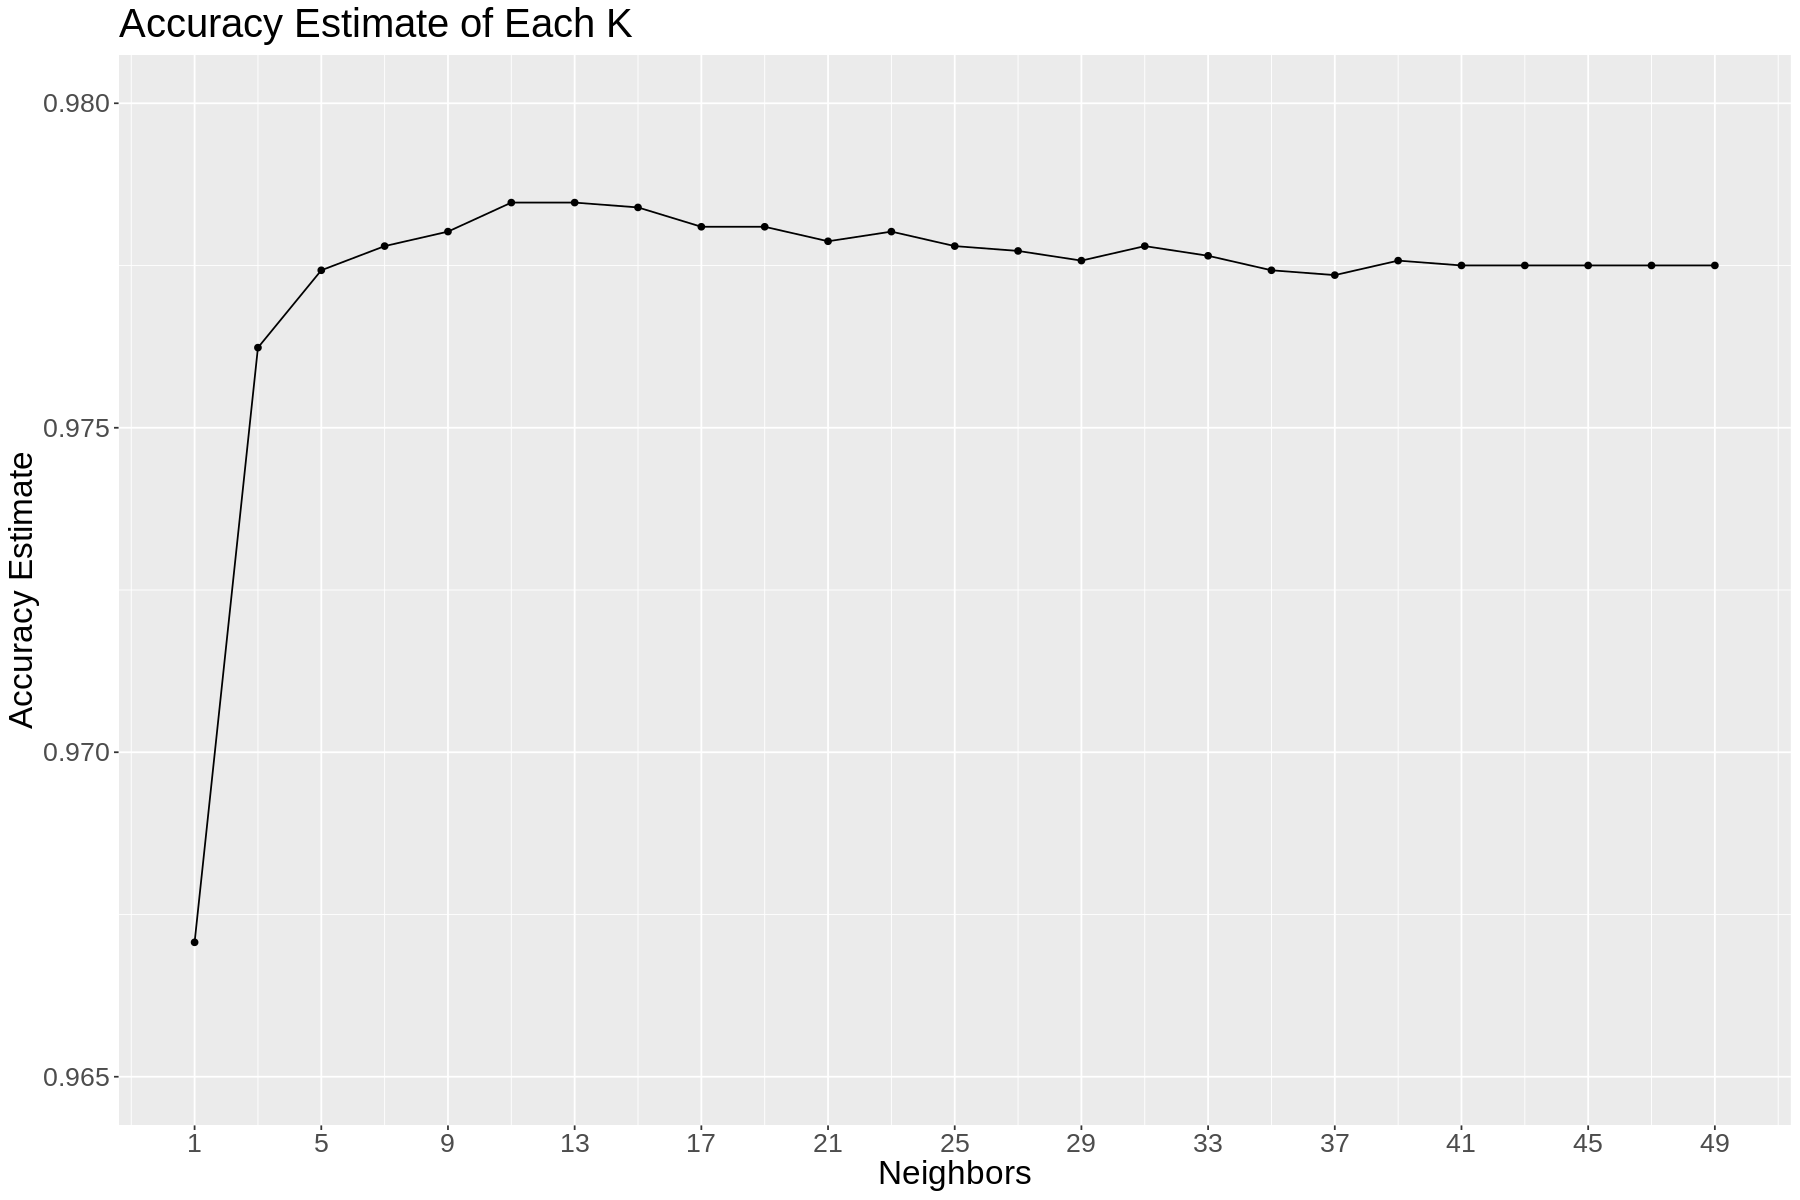

In [31]:
options(repr.plot.width = 15, repr.plot.height = 10)
# plotting the accuracy of each k neighbors to select the optimal value of k
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy Estimate of Each K") +
    scale_x_continuous(breaks = seq(1, 50, 4)) +
    scale_y_continuous(limits = c(0.965, 0.98)) +
    theme(text = element_text(size = 20))
cross_val_plot

In [37]:
set.seed(2023) 

pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
    set_engine("kknn") |>
    set_mode("classification")

pulsar_fit <- workflow() |>
    add_recipe(pulsar_recipe) |>
    add_model(pulsar_spec) |>
    fit(data = pulsar_train)

pulsar_predictions <- predict(pulsar_fit, pulsar_test) |>
    bind_cols(pulsar_test)
pulsar_predictions |> head(6)

.pred_class,mean_profile,deviation_profile,kurtosis_profile,skewness_profile,mean_dmsnr,deviation_dmsnr,kurtosis_dmsnr,skewness_dmsnr,class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
non_pulsar,130.38281,39.84406,-0.1583228,0.3895404,1.220736,14.37894,13.539456,198.23646,non_pulsar
non_pulsar,107.25781,39.49649,0.4658820,1.1628771,4.079431,24.98042,7.397080,57.78474,non_pulsar
non_pulsar,134.96094,49.55433,-0.1353038,-0.0804696,10.696488,41.34204,3.893934,14.13121,non_pulsar
pulsar,99.36719,41.57220,1.5471970,4.1541060,27.555184,61.71902,2.208808,3.66268,pulsar
non_pulsar,95.86719,42.05992,0.3263869,0.8035018,1.832776,12.24897,11.249331,177.23077,non_pulsar
non_pulsar,117.36719,53.90861,0.2579534,-0.4050491,6.018395,24.76612,4.807783,25.52262,non_pulsar


In [38]:
pulsar_metrics <- pulsar_predictions |>
    metrics(truth = class, estimate = .pred_class) |>
    select(.metric, .estimate) |>
    head(1)
pulsar_metrics

.metric,.estimate
<chr>,<dbl>
accuracy,0.9794413


### Addressung the High Prediction Accuracy
The reason why the given model has an extremely high prediction accuracy of 97.94% is due to the dataset being extremely overfitted with the non-pulsar star data comprising of about 91% of the dataset and the Pulsar stars comprising the remaining 9%.
To counter this situation, we can use "step_upsample()" function to scale the data and create more Pulsar star datapoints to have a better model.

In [39]:
pulsar_matrix <- pulsar_predictions |>
    conf_mat(truth = class, estimate = .pred_class)
pulsar_matrix

            Truth
Prediction   non_pulsar pulsar
  non_pulsar       4037     65
  pulsar             27    346

In [40]:
pulsar_accuracy <- pulsar_predictions |>
    mutate(accuracy = ifelse(.pred_class == class, "correct", "incorrect")) |>
    mutate(observation = 1:n())
pulsar_accuracy |> head(6)

.pred_class,mean_profile,deviation_profile,kurtosis_profile,skewness_profile,mean_dmsnr,deviation_dmsnr,kurtosis_dmsnr,skewness_dmsnr,class,accuracy,observation
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<int>
non_pulsar,130.38281,39.84406,-0.1583228,0.3895404,1.220736,14.37894,13.539456,198.23646,non_pulsar,correct,1
non_pulsar,107.25781,39.49649,0.4658820,1.1628771,4.079431,24.98042,7.397080,57.78474,non_pulsar,correct,2
non_pulsar,134.96094,49.55433,-0.1353038,-0.0804696,10.696488,41.34204,3.893934,14.13121,non_pulsar,correct,3
pulsar,99.36719,41.57220,1.5471970,4.1541060,27.555184,61.71902,2.208808,3.66268,pulsar,correct,4
non_pulsar,95.86719,42.05992,0.3263869,0.8035018,1.832776,12.24897,11.249331,177.23077,non_pulsar,correct,5
non_pulsar,117.36719,53.90861,0.2579534,-0.4050491,6.018395,24.76612,4.807783,25.52262,non_pulsar,correct,6


## Plotting the Accuracy

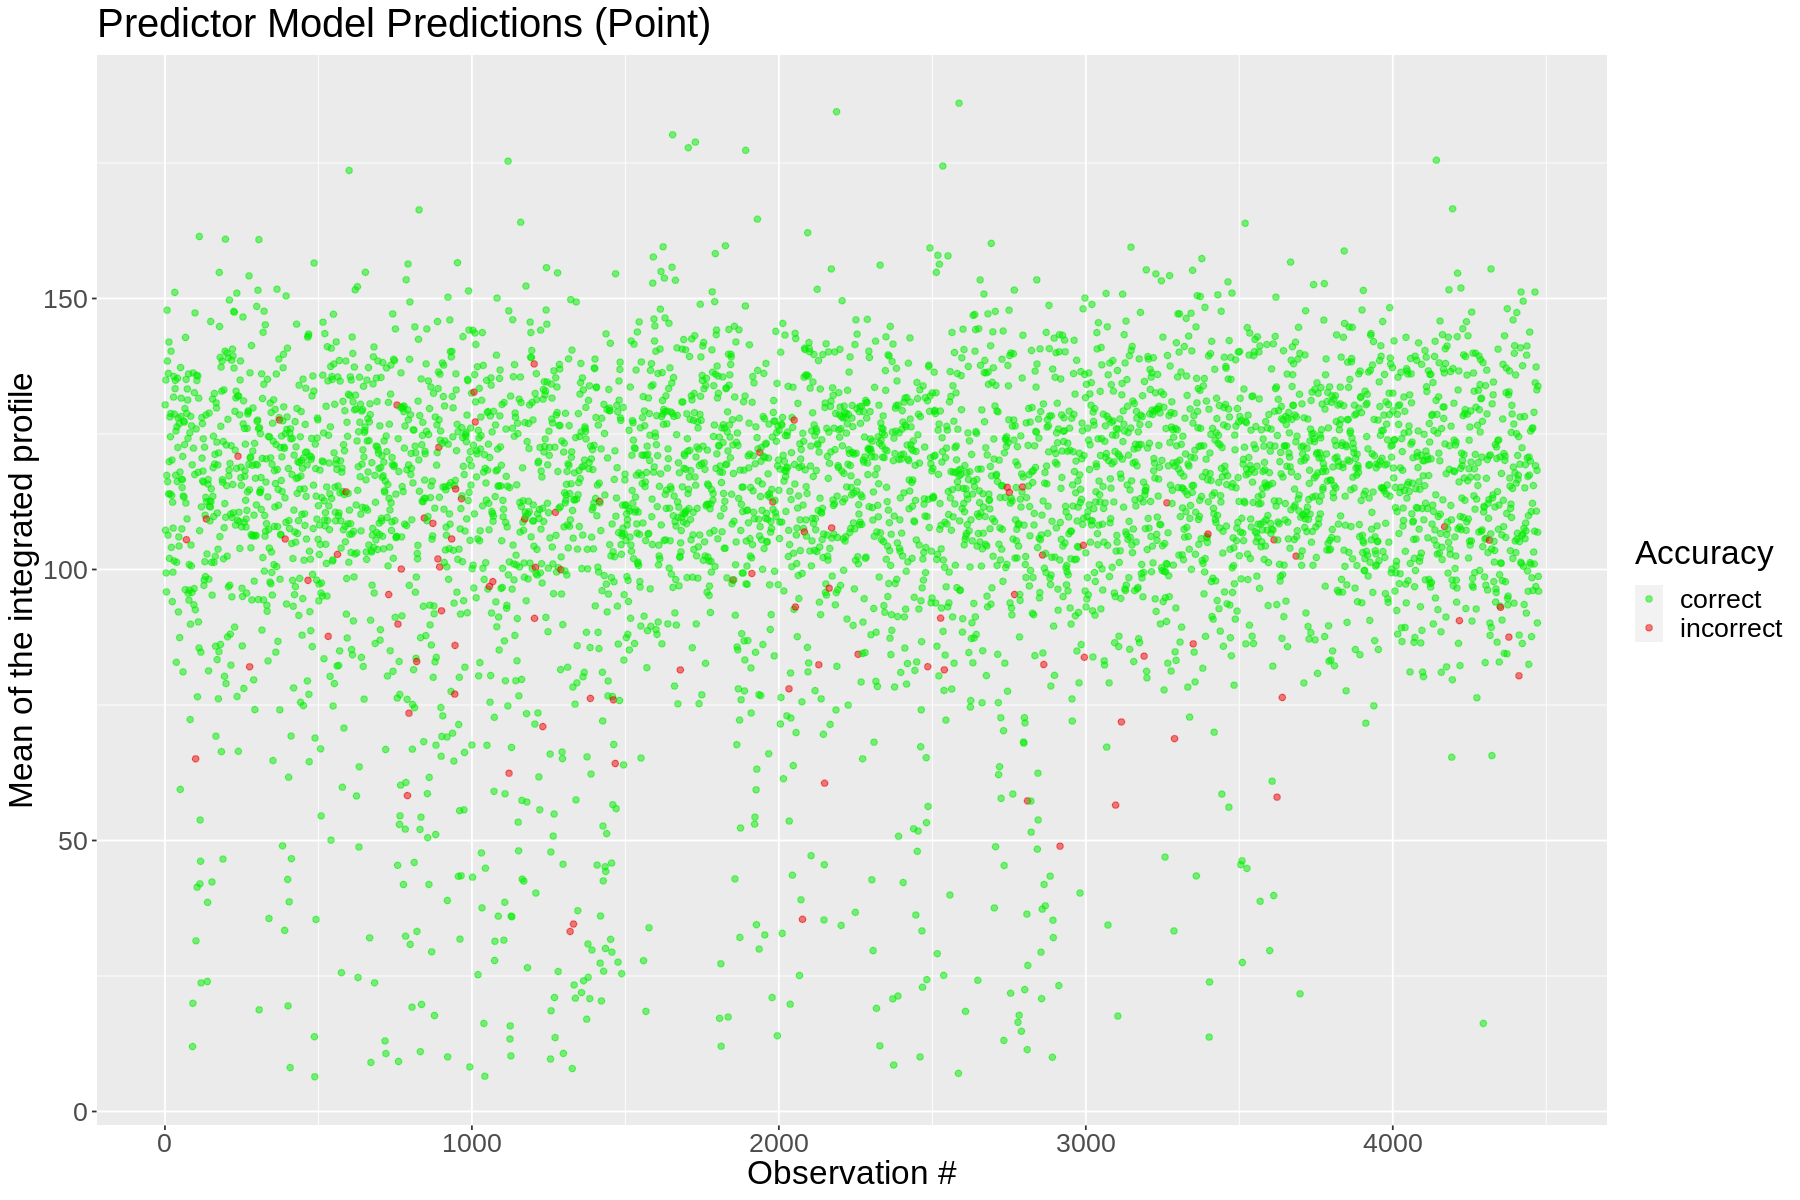

In [41]:
options(repr.plot.width = 15, repr.plot.height = 10)

pulsar_point <- pulsar_accuracy |>
    ggplot(aes(x = observation, y = mean_profile, colour = accuracy)) +
    geom_point(alpha = 0.5) +
    labs(x = "Observation #", y = "Mean of the integrated profile", colour = "Accuracy", title = "Predictor Model Predictions (Point)") +
    theme(text = element_text(size = 20))+
    scale_color_manual(values=c("#00EE00", "#EE0000"))
pulsar_point

## Discussion

We expect to be able to classify observed signals as coming from a pulsar star or not to the highest degree of accuracy and precision as possible by also using our findings of the best value of K.

##### Impact of findings

These findings could lead to scientific breakthroughs in the fields of physics and astronomy, such as how atoms behave under extreme pressure. Additionally, light emitted from pulsars can be used to calculate distances between cosmic objects and detect gravitational waves.

##### Future questions

This could lead to future questions involving more specific details of stars that are classified as pulsars, such as using other cosmic data to classify whether a star is pulsar. Also, looking at the accuracy of our model, there may be a more accurate way to classify pulsars using other engines or algorithms rather than KNN.

## References

R. J. Lyon, HTRU2, DOI: 10.6084/m9.figshare.3080389.v1.

R. J. Lyon, 'Why Are Pulsars Hard To Find?', PhD Thesis, University of Manchester, 2016.

R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656

Lea. R. 2023. What are pulsars? Space.com. https://www.space.com/32661-pulsars.html